**Only work with tiff images for now !**

The user will select a profile region (rectangle). The pixels in the smallest width of the rectangle will be added. Then the profile ploted for each of the image index. This will allow for example to follow the flow of water as it enters a crack.

## 1. Prepare logbook 

In [2]:
from IPython.html import widgets
from IPython.display import display

from pprint import pprint
from ipywidgets.widgets import interact

/Users/j35/anaconda/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
import os, os.path

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

import matplotlib as mpl

In [91]:
font = {'family' : 'monospace',
       'size' : '14'}
mpl.rc('font', **font)

In [5]:
from PIL import Image
import numpy as np

## 2. Select Data Files

In [6]:
default_dir = '/Volumes/My Book Thunderbolt Duo/IPTS/IPTS-16259/Day_4_CO-4_Uptake/'

In [7]:
from PyQt4 import QtGui
%gui qt

In [8]:
try:
    from PySide import QtCore, QtGui
except ImportError:
    from PyQt4 import QtCore, QtGui

def gui_fname(dir=None):
    """Select a directory
    """
    if dir is None: dir ='./'
    dir_name = QtGui.QFileDialog.getOpenFileNames(None, "Select TIFF Data Files ...",
                                                  dir)
                                                 
    return dir_name

In [9]:
%gui qt
list_files = gui_fname(dir = default_dir)
#pprint(list_files)

## 3. Load the data 

In [10]:
w = widgets.IntProgress()
w.max = len(list_files)
display(w)
index = 0

array_images = []
for ref, file in enumerate(list_files):
    
    _image = np.asarray(Image.open(file))
    array_images.append(_image)
    index += 1
    w.value = index

## 4. Select Range of Image to Work On 

Using the Image Index (*image_index*) slider, narrow down the range of images that we will use in the analysis. Make sure you play wit the **min_intensity** and **max_intensity** to change the contrast of the images. 

### a. Default Contrast  and Profile Range

In [65]:
min_intensity = 0
max_intensity = 500

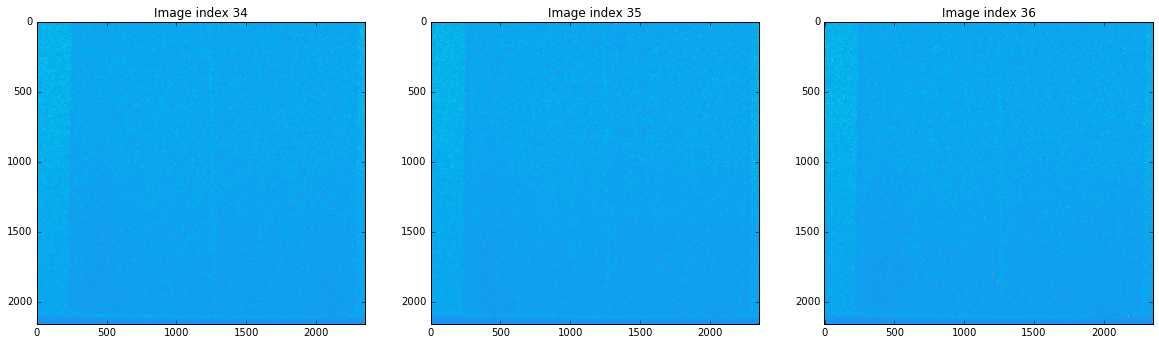

In [64]:
def plot_images(file_index):
    
    data_left = array_images[file_index-1]
    data      = array_images[file_index]
    data_right = array_images[file_index+1]
    
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1,3)
    
    ax_img = plt.subplot(gs[0,0])
    ax_img.imshow(data_left, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
    ax_img.set_title("Image index %d" %(file_index-1))

    ax_img = plt.subplot(gs[0,1])
    ax_img.imshow(data, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
#    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))
    ax_img.set_title("Image index %d" %file_index)
    

    ax_img = plt.subplot(gs[0,2])
    ax_img.imshow(data_right, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
    ax_img.set_title("Image index %d" %(file_index+1))
    

    
number_of_files = len(list_files)
range_selection = interact(plot_images,
                          file_index = widgets.IntSlider(min=1, 
                                                         max=number_of_files-2, 
                                                         value=35, 
                                                         step=1, 
                                                         description="Image Index"))


### b. Image range

Using previous plot, you determined that the range of images of interest is between:


In [66]:
first_image_index = 35
last_image_index = 80

## 5. Select Profile Region 

In [67]:
[image_height, image_width] = array_images[0].shape
working_array_images = array_images[first_image_index : last_image_index+1]
working_list_files = list_files[first_image_index : last_image_index+1]

default_profile_range

In [71]:
x_left = 1175
y_top = 0
width = 165
height = 2159

[1216, 0, 65, 2085, <matplotlib.figure.Figure at 0x120d21ac8>]

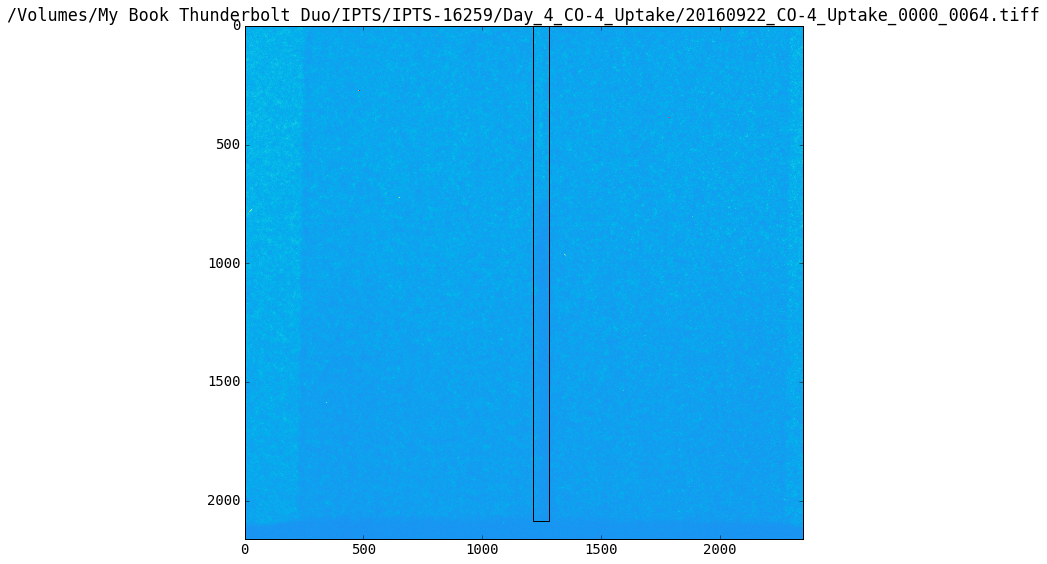

In [72]:
def plot_images_with_box(file_index, x_left, y_top, width, height):
    
    data = working_array_images[file_index][:, :]
    
    fig_box = plt.figure(figsize=(10, 10))
    ax_img = plt.subplot(111)
    
    ax_img.imshow(data, cmap = 'rainbow',
                  interpolation = None,
                  vmin = min_intensity,
                  vmax = max_intensity)
    ax_img.set_title(working_list_files[file_index])
    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))
    
    return [x_left, y_top, width, height, fig_box]

number_of_files = len(list_files)
profile = interact(plot_images_with_box,
                  file_index = widgets.IntSlider( min=0, max=len(working_list_files), 
                                                 value=42, step=1, 
                                                 description='Image index'),
                  x_left = widgets.IntSlider( min=0, max=image_width-1, step=1, value= x_left),
                  y_top = widgets.IntSlider( min=0, max=image_height-1, step=1, value= y_top), 
                  width = widgets.IntSlider( min=0, max=image_width-1, step=1, value= width), 
                  height = widgets.IntSlider( min=0, max=image_height-1, step=1, value=height))
    

## 5. calculate profile over range of images 

In [145]:
print(profile.widget.kwargs)
y_top = profile.widget.kwargs['y_top']
x_left = profile.widget.kwargs['x_left']
width = profile.widget.kwargs['width']
height = profile.widget.kwargs['height']

{'file_index': 14, 'y_top': 0, 'height': 2085, 'width': 65, 'x_left': 1216}


In [146]:
w = widgets.IntProgress()
w.max = len(working_list_files)-1
display(w)
index = 0

profile_array = []
for _image in working_array_images:
    _profile_image = _image[y_top:y_top+height, x_left:x_left+width]
    _value = np.sum(_profile_image)
    profile_array.append(_value)
    w.value = index
    index += 1

## 6. Display global profile 

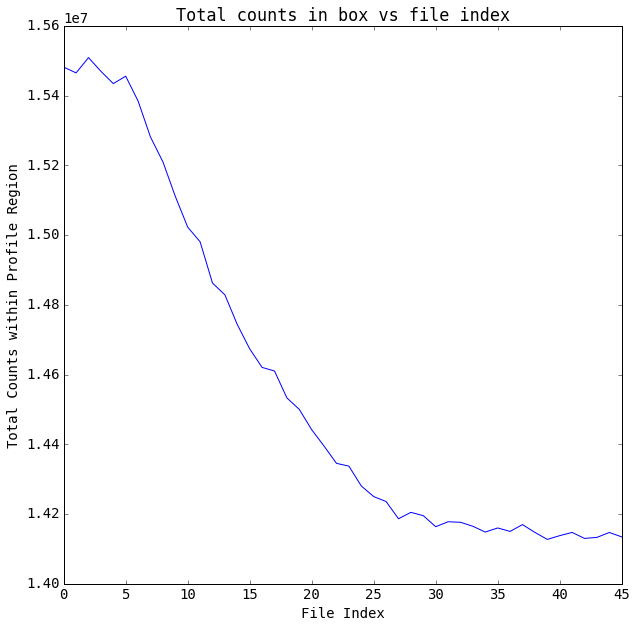

In [147]:
fig_profile = plt.figure(figsize=(10, 10))
plt.plot(profile_array)  
plt.title("Total counts in box vs file index")
plt.xlabel("File Index")
plt.ylabel("Total Counts within Profile Region")

## 7. Display Profile vs File Index  

In order to improve the statitics, **rebin** allows to combine those pixels in the y-direction. 

In [159]:
rebin = 5  #number of pixels in y direction to rebin (to improve statistic)

Calculate the profile
 - rebin the pixels as defined by the **rebin** parameter along the y-axis
 - sum all the pixels along the x-axis

In [154]:
w = widgets.IntProgress()
w.max = len(working_list_files)-1
display(w)
index = 0
rebin_range = np.arange(0, height-y_top, rebin)

profile_1d = []
def calculate_1d_profiles():
    
    for _index, _array in enumerate(working_array_images):
        _roi_array = _array[y_top:y_top+height, x_left:x_left+width]
        _width_profile = np.sum(_roi_array,1)
        rebin_width_profile = [sum(_width_profile[x:x+rebin]) for x in rebin_range]
        profile_1d.append(rebin_width_profile)
        _index += 1
        w.value = _index
    
calculate_1d_profiles()

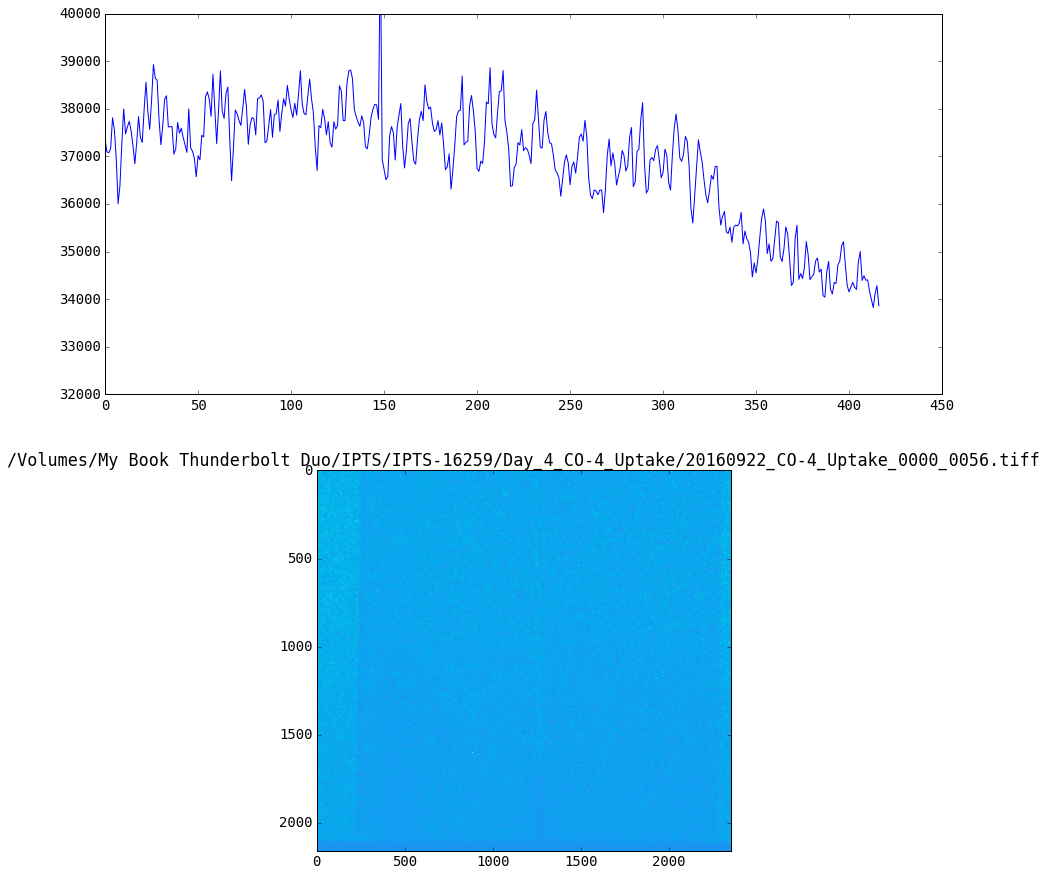

In [158]:
counts_max = 40000
counts_min = 32000

def plot_profile(file_index):
    
    data_1d = profile_1d[file_index]
    data_2d = working_array_images[file_index]
    
    fig = plt.figure(figsize=(15,15))
    
    plt.subplot(211)
    plt.plot(data_1d)
    plt.ylim([counts_min, counts_max])
    
    ax_img = plt.subplot(212)
    ax_img.imshow(data_2d, cmap = 'rainbow',
                  interpolation = None,
                  vmin = min_intensity,
                  vmax = max_intensity)
    ax_img.set_title(working_list_files[file_index])

number_of_files = len(working_list_files)
range_selection = interact(plot_profile,
                          file_index = widgets.IntSlider(min=0, 
                                                         max=number_of_files-1, 
                                                         value=0, 
                                                         step=1, 
                                                         description="Image Index"))